# Generative Modeling for Relational Databases

Original article: https://dspace.mit.edu/handle/1721.1/109616

The following notebook addresses a data-frame generation technique that uses a statistical generative model. It focuses on a standalone table meaning that the aim is to model the table independently of any other data. 

The number of attributes (number of columns) of the table will be referred to as $n$.

This method will apply the following steps:

- Data loading
- Data pre-processing (converting categorical attributes to numerical)
- Modeling and generation 
- Data post-processing (converting back numerical generated values to categorical)
- Quality assessment of the generated data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import scipy.stats as stats
from tqdm import tqdm
from scipy.stats import exponweib
from math import sqrt
from scipy.stats.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

## 1. Loading Data

Loading a dataset

In [2]:
%%sh
ls -laFh ../data/statistical-generative-modeling-sample.csv.bz2

-rw-r--r-- 1 auriane auriane 4,4M juil.  7 14:58 ../data/statistical-generative-modeling-sample.csv.bz2


In [3]:
df = pd.read_csv("../data/statistical-generative-modeling-sample.csv.bz2")

In [4]:
df

,SEATS,PASSENGERS,FREIGHT,DISTANCE,RAMP_TO_RAMP,AIR_TIME,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,AIRCRAFT_TYPE,MONTH,Unnamed: 14
0,0.0,0.0,331088.0,216.0,1708.0,780.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12402,ITO,620,6,NaN
1,0.0,0.0,1081490.0,163.0,5695.0,1782.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12758,KOA,620,6,NaN
2,0.0,0.0,570900.0,102.0,2006.0,884.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12982,LIH,620,6,NaN
3,0.0,0.0,1206131.0,100.0,6146.0,1704.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,13830,OGG,620,6,NaN
4,0.0,0.0,180778.0,216.0,2135.0,1092.0,1TQ,Rhoades Aviation dba Transair,12402,ITO,12173,HNL,620,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394121,105984.0,81424.0,511764.0,100.0,34737.0,17951.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,3,NaN
394122,106368.0,74321.0,143112.0,100.0,33693.0,19865.0,HA,Hawaiian Airlines Inc.,13830,OGG,12173,HNL,608,10,NaN
394123,106752.0,71430.0,600636.0,100.0,35319.0,18013.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,10,NaN
394124,107904.0,77703.0,478682.0,100.0,34822.0,18338.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,5,NaN


For the purpose of this demonstration we reduce the size of the dataset in order to reduce computation times. The number of attributes is also reduced to focus on illustrative purposes.

In [5]:
reduced_size = 500

In [6]:
df_sample = df[["DISTANCE", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"]][:reduced_size]

We display the reduced data-frame:

In [7]:
df_sample

,DISTANCE,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID
0,216.0,12173,12402
1,163.0,12173,12758
2,102.0,12173,12982
3,100.0,12173,13830
4,216.0,12402,12173
...,...,...,...
495,122.0,10551,14282
496,145.0,10551,14718
497,38.0,10551,15257
498,117.0,10551,15282


## 2. Useful functions

Following are some useful functions that will be used throughout this notebook:

Draws a value according to a gaussian truncated distribution with given parameters:

In [8]:
def gauss_truncated(lower, upper, mu, sigma):
    
    """
    Computes a value according to a gaussian truncated distribution
    :param lower: (float) lower bound  
    :param upper: (float) upper bound
    :param mu: (float) mean of the gaussian
    :param sigma: (float) standard deviation of the gaussian
    :return: (float) x, value drawn according to gaussian truncated distribution
    """
    
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    x = X.rvs()
    return x

Checks if a matrix is symmetric, and positive definite:

In [9]:
def is_symmetric(M, rtol=1e-05, atol=1e-08):
    return np.allclose(M, M.T, rtol=rtol, atol=atol)

def is_pos_def(M):
    return np.all(np.linalg.eigvals(M) > 0)

Computes Cholesky decomposition of symmetric positive definite matrix:

In [10]:
def cholesky(M):
    
    """
    Performs Cholesky decomposition of a matrix
    :param M: symmetric and positive definite matrix
    :return: lower triangular matrix L from the decomposition
    """
        
    assert is_symmetric(M), "The matrix for Cholesky decomposition is not symmetric"
    assert is_pos_def(M), "The matrix for Cholesky decomposition is not positive definite"
    
    n = len(M)
    L = np.zeros((n, n))

    # performs the Cholesky decomposition
    for i in range(n):
        for k in range(i+1):
            tmp_sum = sum(L[i][j] * L[k][j] for j in range(k))
            
            if (i == k): 
                L[i][k] = sqrt(M[i][i] - tmp_sum)
            else:
                L[i][k] = (1.0 / L[k][k] * (M[i][k] - tmp_sum))
    return L

Functions for graphical display:

In [11]:
def remove_ticks(ax):
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
def remove_splines(ax, spl):
    for s in spl:
        ax.spines[s].set_visible(False)  

def modify_splines(ax, lwd, col):    
    for s in ['bottom', 'left','top','right']:
        ax.spines[s].set_linewidth(lwd)
        ax.spines[s].set_color(col) 

## 3. Data pre-processing

### Converting categorical data to numerical 

The dataset from which we want to generate data might contain different types of values:
- Numerical: values that have meaning as a measurement (distance, gross weight etc.)
- Categorical: a collection of information that is divided into groups (origin country code, etc.). They can take numerical values but those numbers don't have mathematical meaning

For example, in our toy data-frame, "ORIGIN_AIRPORT_ID" and "DEST_AIRPORT_ID" are categorical data.

The issue is that a statistical model cannot be directly built from categorical data. This is why we have to convert categorical data to numerical.

_To do: automate getting categorical fields thanks to metadata. For now, categorical attributes manually assessed in the categorical_fields list._

In [12]:
categorical_fields = ["ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"]

All categorical attributes are converted to numerical [0,1] values using the following method:
- Discrete values are first sorted in descending order based on their proportion in the dataset. 
- The [0,1] interval is split into disjoint sections $[a_c,b_c]$ based on the proportion of each category c. 

Then to convert a categorical attribute we follow these steps for each row:
- we find the interval $[a_c, b_c]$ that corresponds to the categorical value.
- we sample a numerical value from a truncated Gaussian distribution with $\mu$ as the center of the interval and $\sigma = \frac{b_c-a_c}{6}$

In [13]:
def categorical_to_numerical(df, categorical_fields):
    
    
    """
    Converts categorical data attributes to numerical
    :param df: initial pandas data-frame  
    :param categorical_fields: list of strings (attributes names that will be converted from categorical
    to numerical
    :return:  dictionary where keys are names of numerical fields computed from categorical, and values are
    pandas data-frames with sorted categorical values and corresponding intervals
    """
    

    transitional_dfs = {}
    df_categorical = df.copy()
    
    for categorical_field in categorical_fields:
        
        assert (categorical_field in df), "This field doesn't exist in the database"

        # adding empty column for new numerical field
        df_categorical[categorical_field + "_NUM"] = 0

        #data-frame of unique discrete values from categorical field and associated proportions (decreasing order)
        unique_values_df = df[categorical_field\
                             ].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='counts')
        
        # building the intervals
        unique_values_df["interval_down"] = ""
        unique_values_df["interval_up"] = ""
        for index, row in unique_values_df.iterrows():
            if index == 0:
                unique_values_df.loc[index, "interval_down"] = 0
                unique_values_df.loc[index, "interval_up"] = row["counts"]   
            else:
                unique_values_df.loc[index, "interval_down"] =  \
                    unique_values_df[index-1:index]["interval_up"].item()
                unique_values_df.loc[index, "interval_up"] = \
                    unique_values_df[index-1:index]["interval_up"].item() + row["counts"]
        
        transitional_dfs[categorical_field + "_NUM"] = unique_values_df
        
        # filling new numerical column
        for index, row in df.iterrows():
            value = row[categorical_field]
            i = unique_values_df[unique_values_df["unique_values"] == value].index.tolist()[0]

            # drawing value from truncated gaussian distribution
            a = unique_values_df[i:i+1]["interval_down"].item()
            b = unique_values_df[i:i+1]["interval_up"].item()
            mu = a + (b-a)/2
            sigma = (b-a)/6
            x = gauss_truncated(a, b, mu, sigma)
            df_categorical.loc[index, categorical_field + "_NUM"] = x
        df_categorical = df_categorical.drop(categorical_field, axis=1)
        
    return df_categorical, transitional_dfs

In [14]:
df_sample_num, transitional_dfs = categorical_to_numerical(df_sample, categorical_fields)

We display the sample data-frame where categorical fields (here there are two: "ORIGIN_AIRPORT_ID" and "DEST_AIRPORT_ID") have been converted to numerical fields:

In [15]:
df_sample_num

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,216.0,0.421907,0.493334
1,163.0,0.422821,0.503769
2,102.0,0.418035,0.532823
3,100.0,0.424159,0.444687
4,216.0,0.538417,0.247068
...,...,...,...
495,122.0,0.265670,0.920597
496,145.0,0.246010,0.994978
497,38.0,0.264512,0.897150
498,117.0,0.260686,0.769247


## 4. Modeling and generation

We can now start building our model. 

We will first begin by computing for each attribute, the distribution and parameters (according to a predefined list of known distributions) that best fits the empirical distribution.

We will then convert all of the column distributions to standard normal distributions, in order to compute the covariance matrix of different attributes without any bias that would be induced by the shapes of the distributions. 


After this is done, we can generate new rows.

In [16]:
class Distribution(object):
    
    
    """
    Given an initial set of data, computes the best fitted distribution and corresponding parameters 
    from predefined list of known distributions
    """
    
    
    def __init__(self,distr_names_list=["norm", "lognorm", "expon", "uniform", "truncnorm", \
                                       "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]):
        self.distr_names = distr_names_list
        self.distr_results = []
        self.params = {}
        self.distribution_name = ""
        self.pvalue = 0
        self.param = None
        self.is_fitted = False
        
        
    def fit(self, initial_data):
        
        """
        :param initial_data: pandas series of initial data that has to be fitted 
        :return: name of the distribution that fits the best and associated p value (computed by ks test)
        """
        
        #going through all distributions
        for distr_name in self.distr_names:
            
            # best parameters for this distribution
            distr = getattr(stats, distr_name)
            param = distr.fit(initial_data)
            self.params[distr_name] = param
            
            #Kolmogorov-Smirnov test for these parameters
            D, p = stats.kstest(initial_data, distr_name, args=param)
            self.distr_results.append((distr_name,p))
            
        #select the best fitted distribution
        best_distr, best_p = (max(self.distr_results,key=lambda tup:tup[1]))
        
        #store the name of the best fit and its p value and parameters
        self.distribution_name = best_distr
        self.pvalue = best_p
        self.param = self.params[best_distr]
        self.is_fitted = True
        
        return self.distribution_name, self.pvalue
    
    
    def random(self, n = 1):
        
        """
        :param n: int, number of samples that will be drawn according to the best fitted distribution
        :return: array of samples drawn according to the best fitted distribution
        """
        
        if self.is_fitted:
            param = self.params[self.distribution_name]
            distr = getattr(scipy.stats, self.distribution_name)
            return distr.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
        else:
            raise ValueError('Must first run the fit method.')
          
        
    def plot(self,initial_data, name, ax, fitted_distr=True, lab="Actual"):
        
        """
        :param initial_data: pandas series of initial data that has to be fitted
        :param name: string of the name of the attribute that is being fitted
        :pram ax: matplotlib ax for display
        :param fitted_distr: bool (indicates is fitted distribution is plotted on top of initial distribution)
        :param lab: string, label for initial data
        """  
        
        # for graphic view
        remove_ticks(ax)
        modify_splines(ax, lwd=0.75, col='0.8')
        remove_splines(ax, ['top','right'])
        ax.patch.set_facecolor('0.93')
        ax.grid(True, 'major', color='0.98', linestyle='-', linewidth=1.0)
        ax.set_axisbelow(True)
        
        
        x = self.random(n=len(initial_data))
        if fitted_distr:
            ax.hist(x, bins=30, alpha=0.4, label='Fitted', density=True, ec="k", histtype='stepfilled')
        ax.hist(initial_data, bins=30, alpha=0.4, label=lab, density=True, ec="k", histtype='stepfilled')
        ax.set_title(name)
        ax.legend(loc='upper right')

In [17]:
class Model():
    
    """
    Computes the generative model from an initial data-frame
    """
    
    def __init__(self, dataframe):
        self.df = dataframe
        self.df_normed = pd.DataFrame(columns=self.df.columns)
        self.distributions = {}
        self.distr_computed = False
        
        
    def compute_distributions(self, display_results=True):
        
        """
        Computes the best fitted distribution for each attribute and prints its name, associated p value
        (computed from ks test), and parameters
        :param display_results: bool that indicates whether information on the fitted distribution will be printed
        """
        
        for attribute in self.df:
            distr= Distribution()
            distr.fit(self.df[attribute])
            self.distributions[attribute] = distr
            self.distr_computed = True
            if display_results:
                print("The distribution that fits the best attribute "+ attribute + " is "+ distr.distribution_name)
                print("The pvalue is", distr.pvalue, " with the following parametrers:", distr.param)
                print("\n")
           
        
    def gaussian_copula(self):
        
        """
        Converts all column distributions to standard normal 
        """
        
        if self.distr_computed:
            
            # going through the rows
            for index, row in self.df.iterrows():
                values = {}
                initial_vect = np.array(row)
                transformed_vect = np.zeros(len(initial_vect))
                
                #going through the columns
                for i, attribute in enumerate(self.df):
                    
                    # getting distribution of the column
                    distr = getattr(stats, self.distributions[attribute].distribution_name)
                    param = self.distributions[attribute].param
                    norm = getattr(stats, "norm")
                    
                    # converting value to get standard normal distribution
                    transformed_vect[i] = norm.ppf(distr.cdf(initial_vect[i], *param[:-2], loc=param[-2], \
                                                             scale=param[-1]))
                    #transformed_vect[i] = norm.ppf(distr.cdf(initial_vect[i]))
                    values[attribute] = transformed_vect[i]
            
                # adding normed results to a new data-frame
                new_row = pd.Series(values, name="new row")
                self.df_normed = self.df_normed.append(new_row, ignore_index=True)
                
            with pd.option_context('mode.use_inf_as_null', True):
                self.df_normed = self.df_normed.dropna()
                
        else:
            raise ValueError('Must compute the distributions first.')            
        

    def sample(self):
        
        """
        :return: generated_row, numpy array (data-frame row) computed as a sample of the modeled distribution
        """
        
        if not self.df_normed.empty:
            
            # computing covariance matrix for the normed data-frame
            cov_matrix = self.df_normed.cov()
            cov_matrix = np.array(cov_matrix)
            nb_col = self.df_normed.shape[1]
            
            # computing cholesky decomposition
            L = cholesky(cov_matrix)

            mean = np.zeros(nb_col)
            cov = np.eye(nb_col)

            # generating new vector according to formula
            V = np.random.multivariate_normal(mean, cov)
            U = L@V
            generated_row = np.zeros(nb_col)
            for i, attribute in enumerate(self.df):
                distr = getattr(stats, self.distributions[attribute].distribution_name)  
                param = self.distributions[attribute].param
                norm = getattr(stats, "norm")
                generated_row[i] = distr.ppf(norm.cdf(U[i]), *param[:-2], loc=param[-2], scale=param[-1])
                
            return generated_row
            
        else:
            raise ValueError ("Must run gaussian_copula method first.")
            
    
    def generate_data(self, size):
    
        """
        Generates a data-frame of required size
        :param size: int, number of rows that will be generated
        :return: pandas data-frame with generated values
        """
    
        df_gen = pd.DataFrame(columns=self.df.columns)
        for index in range(size):
            values = {}
            row = self.sample()
            for i, attribute in enumerate(df_gen):
                values[attribute] = row[i]
            new_row = pd.Series(values, name="new row")
            df_gen = df_gen.append(new_row, ignore_index=True)
        return df_gen
        
        
    def plot_distributions(self, fitted_distr=True, lab="Actual"):
        
        """
        Plots the distribution of each attribute of the main data-frame
        :param fitted_distr: bool (indicates is fitted distributions will be plotted on top of 
        initial distributions)
        :param lab: string, label for initial data
        """
        
        if self.distr_computed:
            for attribute in self.df:
                fig, ax = plt.subplots()
                self.distributions[attribute].plot(self.df[attribute], attribute, ax, fitted_distr, lab)
                plt.show()
        else:
            raise ValueError('Must compute the distributions first.')
            
            
            

### Fitting distributions to attributes

We create a Model instance for our toy data-frame.

We compute the best fitted distribution (and associated parameters) for each attribute of our toy data-frame. 

To do so we use a predefined list of distributions. For each type of distribution, we use the fit method of scipy.stats in order to compute the best parameters.

Then, for each type of distribution and associated parameters, we use the __Kolmgorov-Smirnov test__ from scipy.stats to determine which distribution fits the best.

The idea behind this method is that the empirical cdf of an attribute $X_n = (X_1, ..., X_n)$ can be computed trough the following formula, $\forall x \in \mathbb{R}$:
$$\hat{F}_n(x) = \frac{1}{n}\sum_{i=1}^n \mathbb{1}_{X_i \leq x} $$
The test is built on the following hypothesis ($F$ being the unknown distribution of our empirical data, and $F_0$ being one of our predefined well-known distributions): 
$$H_0 = \{F = F_0\}, \quad H_1 = \{F \neq F_0\}$$
With the statistic:
$$\xi_n = \underset{x \in \mathbb{R}}{\sup} |\hat{F}_n(x) - F(x)|$$

We compute this test for all of our known distributions and associated $F_0$, and define the best distribution as the one that has the __higher p-value__ for this test. Indeed, for a given value of the test statistic, the p-value assesses how likely it is that this value be due to random fluctuations of the sample: the smaller the p-value, the more unlikely the realization under $H_0$ (and the more we should be encouraged to reject $H_0$). In other words, the p-value represents the likelihood that the data matches a particular distribution.

In [18]:
Mod = Model(df_sample_num)
Mod.compute_distributions()

The distribution that fits the best attribute DISTANCE is expon
The pvalue is 0.011450506829860175  with the following parametrers: (0.0, 778.388)


The distribution that fits the best attribute ORIGIN_AIRPORT_ID_NUM is exponweib
The pvalue is 0.883358451900452  with the following parametrers: (0.00863164193789388, 110.27743771778859, 0.013081971378632318, 0.9842735378048388)


The distribution that fits the best attribute DEST_AIRPORT_ID_NUM is exponweib
The pvalue is 0.9209846877587317  with the following parametrers: (0.04644571984525876, 21.423277383973595, 0.003853771783621481, 0.9696558280097395)




In order to be able to compare visually, we plot for each attribute the empirical distribution, and its corresponding fitted distribution.

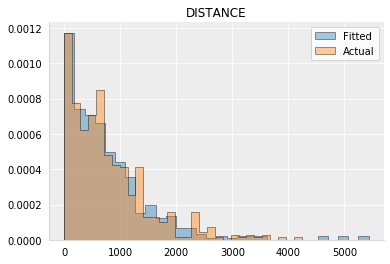

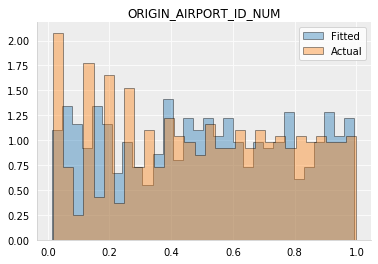

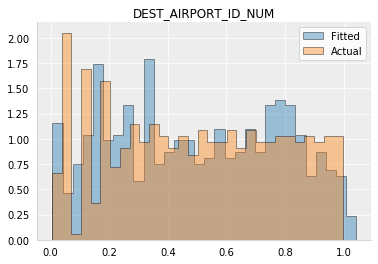

In [19]:
Mod.plot_distributions()

### Gaussian copula to normalize the data

We perform a Gaussian Copula method in order to convert all of the column distributions to standard normal distributions so that the covariance matrix $M$ of the data-frame can be computed without any bias that would be induced by the distribution's shape.



In order to do so we go through the table row by row and consider each row as a vector:
$$X = [x_0, ..., x_{n-1}]$$
We convert the row using the following formula:
$$[x_0, ..., x_{n-1}] \leftarrow [\phi^{-1}(F_0(x_0)), ..., \phi^{-1}(F_{n-1}(x_{n-1}))]$$

Where $\forall i \in \{0, ..., n-1\} $, $F_i$ is the cumulative distribution function (cdf) of our fitted distribution for attribute $i$, and $\phi^{-1}$ is the inverse cdf of the standard normal distribution.

In [20]:
Mod.gaussian_copula()

We display the normalized data-frame:

In [21]:
Mod.df_normed

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,-0.698853,-0.167988,0.016343
1,-0.881828,-0.165645,0.043286
2,-1.161018,-0.177929,0.118518
3,-1.172189,-0.162215,-0.109464
4,-0.698853,0.125918,-0.666458
...,...,...,...
495,-1.057820,-0.600808,1.548774
496,-0.954320,-0.663063,2.310303
497,-1.668116,-0.604403,1.391712
498,-1.082301,-0.616339,0.806976


We plot the histograms of distributions in Copula space in order to visually check that they follow standard normal distributions.

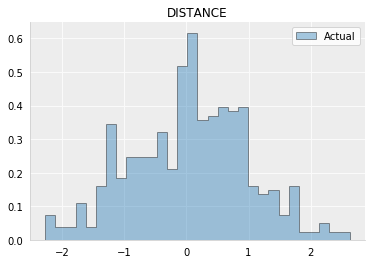

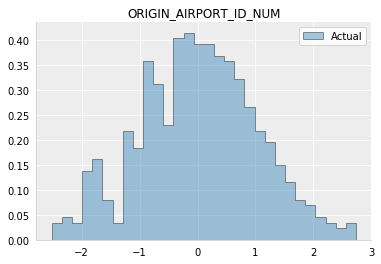

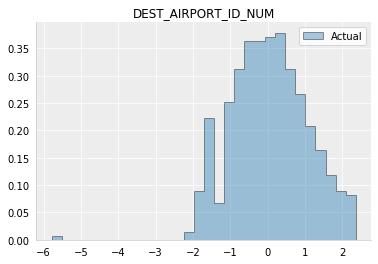

In [22]:
Mod2 = Model(Mod.df_normed)
Mod2.compute_distributions(display_results=False)
Mod2.plot_distributions(fitted_distr=False)

### Data generation

We can then generate new rows. The idea is to draw samples according to the covariance matrix in copula space M, and then convert these samples back to the original space. To do so, we use the following algorithm for each row:
- we generate a random vector V of size $(n-1)$ x $1$ of uncorrelated random variables with each random variable $V_i$ is normal with zero mean and unit covariance $1$. We notice that as V has zero mean, the covariance matrix of V can be written:

$$C(V) = \mathbb{E}(VV^T) = I_n$$

- In order to generate a random vector whose covariance matrix is M, we perform the Cholesky decomposition of M (this is possible since by definition the covariance is symmetric and positive definite): 

$$M = LL^T$$ 

- We then compute the vector $U = LV$. $U$ __has by construction M as covariance matrix__. Indeed, as $\mathbb{E}(V) = 0$, we have $\mathbb{E}(U) = 0$ and:

$$C(U) = \mathbb{E}(UU^T) = \mathbb{E}(LVV^TL^T) = L\mathbb{E}(VV^T)L^T = LL^T = M$$

- We then go back to the original space by applying the inverse of the Gaussian Copula:

$$[u_0, ..., u_{n-1}] \leftarrow [F_0^{-1}(\phi (u_0)), ..., F_{n-1}^{-1}(\phi (u_{n-1}))]$$

We choose the number of sample we would like to generate:

In [23]:
size_of_generation = 500

In [24]:
df_gen = Mod.generate_data(size_of_generation)

In [25]:
df_gen

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,1444.313371,0.832199,0.462555
1,417.266313,0.072669,0.068567
2,261.738937,0.170154,0.145839
3,788.151446,0.728179,0.554992
4,2212.801243,0.025102,0.809954
...,...,...,...
495,2413.751010,0.162346,0.290902
496,661.782616,0.433620,0.875474
497,99.586615,0.651698,0.727765
498,784.161978,0.791870,0.386715


We compare graphically the generated data with the initial data:

In [26]:
Mod_gen = Model(df_gen)
Mod_gen.compute_distributions(display_results=False)

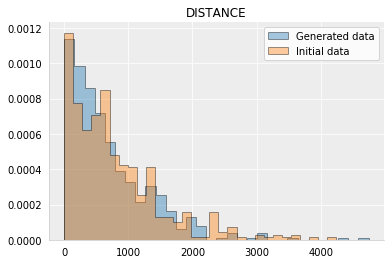

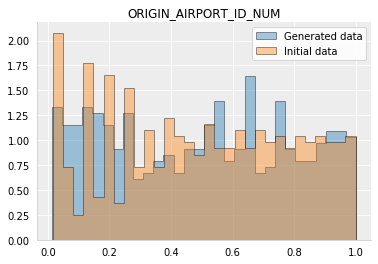

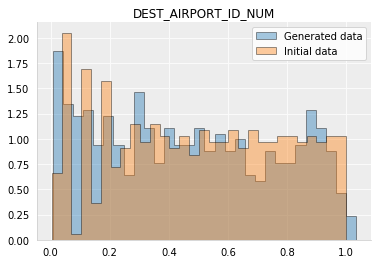

In [27]:
for attribute in Mod_gen.df:
    fig, ax = plt.subplots()
    Mod_gen.distributions[attribute].plot(Mod_gen.df[attribute], attribute, ax, fitted_distr=False, lab="Generated data")
    Mod.distributions[attribute].plot(Mod.df[attribute], attribute, ax, fitted_distr=False, lab="Initial data")
    plt.show()


## 6. Data post-processing

We can then convert back our categorical data from numerical to categorical, by using the intervals we had defined during the pre-processing.

In order to do so, for a value $v \in [0, 1]$, we simply compute the interval it belongs to and return the associated discrete category.

In [28]:
def numerical_to_categorical(df, categorical_fields, transitional_dfs):
    
    """
    Converts numerical data back to categorical
    :param categorical_fields: list of strings (attribute names that have to be converted from numerical 
    to categorical)
    :param transitional_dfs: dictionary returned by categorical_to_numerical function
    :return:
    """
  
    df_final = df.copy()
    for categorical_field in categorical_fields:
        for index, row in df.iterrows():
            discrete_value = 0
            
            # searching for the corresponding interval
            for index2, row2 in transitional_dfs[categorical_field].iterrows():
                if row2["interval_down"]<=df[categorical_field][index]<= row2["interval_up"]:
                    discrete_value = row2["unique_values"]
            df_final.loc[index, categorical_field] = discrete_value
    return df_final

In [29]:
numerical_to_convert = ["ORIGIN_AIRPORT_ID_NUM", "DEST_AIRPORT_ID_NUM"]

In [30]:
df_final = numerical_to_categorical(df_gen, numerical_to_convert, transitional_dfs)

In [31]:
df_final

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,1444.313371,15534.0,12892.0
1,417.266313,16091.0,16091.0
2,261.738937,11193.0,11193.0
3,788.151446,13487.0,12266.0
4,2212.801243,16091.0,12853.0
...,...,...,...
495,2413.751010,13061.0,11042.0
496,661.782616,14730.0,11430.0
497,99.586615,11996.0,11057.0
498,784.161978,11540.0,13303.0


## 5. Quality assessment

### Closeness to real data

In [38]:
class closeness():
    
    """
    Graphical display of closeness between original and generated data 
    """
    
    def __init__(self, init, gen):
        self.initial_df = init
        self.generated_df = gen
        self.correlations = {}
      
        
    def computes_correlations(self):
        
        """
        Computes in numpy arrays pairwise Pearson correlation coefficients for initial and generated data
        """
        
        self.correlations["initial"] = np.zeros((len(self.initial_df.columns), len(self.initial_df.columns)))
        self.correlations["generated"] = np.zeros((len(self.generated_df.columns), len(self.generated_df.columns)))
    
        # pairwise coefficients for initial data
        for index1, col1 in enumerate(self.initial_df.columns):
            for index2, col2 in enumerate(self.initial_df.columns):
                self.correlations["initial"][index1, index2] = pearsonr(self.initial_df[col1].to_numpy(), \
                                                                        self.initial_df[col2].to_numpy())[0]
        # pariwise coefficients for generated data
        for index1, col1 in enumerate(self.generated_df.columns):
            for index2, col2 in enumerate(self.generated_df.columns):
                self.correlations["generated"][index1, index2] = pearsonr(self.generated_df[col1].to_numpy(), \
                                                                          self.generated_df[col2].to_numpy())[0]
            
         
    def set_ax_heatmap(self, ax, hmap, absc, ordo, title):
        
        """
        Sets ax in order to compute 2D heatmap
        :param ax: matplotlib ax for display
        :param hmap: 2D numpy array of pariwise pearson correlation coefficients
        :param absc, ordo: list of strings (column names)
        :param title: string (title of ax for display)
        :return: matplotlib ax with adjustments for display
        """
        
        ax.set_xticks(np.arange(len(absc)))
        ax.set_yticks(np.arange(len(ordo)))
        
        # labels
        ax.set_xticklabels(absc)
        ax.set_yticklabels(ordo)

        # Rotation and alignment of xlabels
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # displaying actual values
        for i in range(len(absc)):
            for j in range(len(ordo)):
                text = ax.text(j, i, np.round(hmap[i, j], 2), ha="center", va="center", color="w")
        
        # title
        ax.set_title(title)
        
        return ax
    
    
        
    def pearson_plot(self):
        
        """
        Computes a 2D heatmap of pairwise Pearson correlations 
        """
        
        # computing correlation matrices
        self.computes_correlations()
        
        # labels for axes
        absc1, absc2 = self.initial_df.columns, self.generated_df.columns
        ordo1, ordo2 = self.initial_df.columns, self.generated_df.columns
        
        # computing heatmaps
        hmap1, hmap2 = self.correlations["initial"], self.correlations["generated"]
        
        # displaying the results
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0] = self.set_ax_heatmap( ax[0], hmap1, absc1, ordo1, "Initial pairwise Pearson correlations")
        ax[1] = self.set_ax_heatmap( ax[1], hmap2, absc2, ordo2, "Generated pairwise Pearson correlations")
        fig.tight_layout()
        ax[0].imshow(hmap1, cmap=plt.cm.pink, alpha=0.9)
        ax[1].imshow(hmap2, cmap=plt.cm.pink, alpha=0.9)
    
        
        
        

In [39]:
res = closeness(df_sample_num, df_gen)

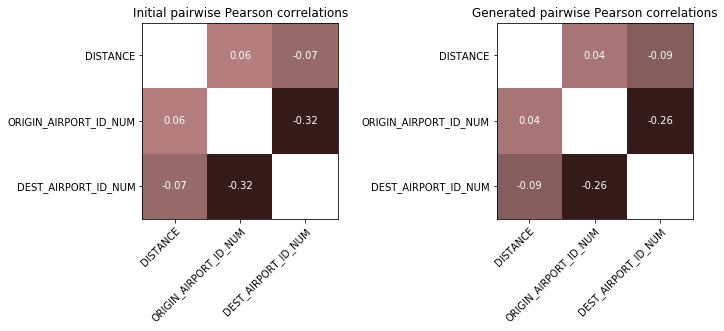

In [40]:
res.pearson_plot()